# Download and process sentinel 2 data

## John Brandt
## December 2, 2020

## Package imports, API import, source scripts

In [131]:
import datetime
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import scipy.sparse as sparse
import seaborn as sns
import yaml

from collections import Counter
from osgeo import ogr, osr
from random import shuffle
from scipy.sparse.linalg import splu
from sentinelhub import WmsRequest, WcsRequest, MimeType
from sentinelhub import CRS, BBox, constants, DataSource, CustomUrlParam
from skimage.transform import resize
from typing import Tuple, List
from scipy.ndimage import median_filter

with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key'] 
        
%matplotlib inline
%run ../src/preprocessing/slope.py
%run ../src/preprocessing/indices.py
%run ../src/downloading/utils.py
%run ../src/preprocessing/cloud_removal.py
%run ../src/preprocessing/whittaker_smoother.py

In [132]:
if os.path.exists("../config.yaml"):
    with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key']
        AWSKEY = key['awskey']
        AWSSECRET = key['awssecret']
else:
    API_KEY = "none"

## Parameters

In [133]:
%run ../src/io/upload.py
uploader = FileUploader(awskey = AWSKEY, awssecret = AWSSECRET)

In [134]:
# Parameters
YEAR = 2019
TIME = ('{}-12-01'.format(str(YEAR - 1)), '{}-02-01'.format(str(YEAR + 1)))
EPSG = CRS.WGS84
IMSIZE = 48

# Constants
starting_days = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30])

# Bounding boxes

In [135]:
def calc_bbox(plot_id: int, df: "DataFrame") -> List:
    """ Calculates the corners of a bounding box from an input
        pandas dataframe as output by Collect Earth Online

        Parameters:
         plot_id (int): plot_id of associated plot
         df (pandas.DataFrame): dataframe of associated CEO survey
    
        Returns:
         bounding_box (list): [(min(x), min(y)),
                              (max(x), max_y))]
    """
    subs = df[df['PLOT_ID'] == plot_id]
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])),
            (max(subs['LON']), max(subs['LAT']))]


def bounding_box(points: List[Tuple[float, float]], 
                 expansion: int = 160) -> ((Tuple, Tuple), str):
    """ Calculates the corners of a bounding box with an
        input expansion in meters from a given bounding_box
        
        Subcalls:
         calculate_epsg, convertCoords

        Parameters:
         points (list): output of calc_bbox
         expansion (float): number of meters to expand or shrink the
                            points edges to be
    
        Returns:
         bl (tuple): x, y of bottom left corner with edges of expansion meters
         tr (tuple): x, y of top right corner with edges of expansion meters
    """
    bl = list(points[0])
    tr = list(points[1])
    inproj = Proj('epsg:4326')
    outproj_code = calculate_epsg(bl)
    outproj = Proj('epsg:' + str(outproj_code))
    bl_utm =  transform(inproj, outproj, bl[1], bl[0])
    tr_utm =  transform(inproj, outproj, tr[1], tr[0])

    distance1 = tr_utm[0] - bl_utm[0]
    distance2 = tr_utm[1] - bl_utm[1]
    expansion1 = (expansion - distance1)/2
    expansion2 = (expansion - distance2)/2
        
    bl_utm = [bl_utm[0] - expansion1, bl_utm[1] - expansion2]
    tr_utm = [tr_utm[0] + expansion1, tr_utm[1] + expansion2]

    zone = str(outproj_code)[3:]
    zone = zone[1:] if zone[0] == "0" else zone
    direction = 'N' if tr[1] >= 0 else 'S'
    utm_epsg = "UTM_" + zone + direction
    return (bl_utm, tr_utm), CRS[utm_epsg]

# Data download

## Cloud and cloud shadow

In [136]:
def identify_clouds(bbox: List[Tuple[float, float]], epsg: 'CRS', time: dict = TIME):
    """ Downloads and calculates cloud cover and shadow
        
        Parameters:
         bbox (list): output of calc_bbox
         epsg (float): EPSG associated with bbox 
         time (tuple): YY-MM-DD - YY-MM-DD bounds for downloading 
    
        Returns:
         cloud_img (np.array): (X, 96, 96) array of cloud probs
         shadows (np.array):  (X, 96, 96) array of shadow binary
         clean_steps (np.array): (N,) array of clean idx
         cloud_dates (np.array): (N,) array of clean cloud datets
    """
    box = BBox(bbox, crs = epsg)
    cloud_request = WcsRequest(
        layer='CLOUD_NEW',
        bbox=box, time=time,
        resx='160m', resy='160m',
        image_format = MimeType.TIFF_d8,
        maxcc=0.75, instance_id=API_KEY,
        custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
        time_difference=datetime.timedelta(hours=96))

    shadow_request = WcsRequest(
        layer='SHADOW',
        bbox=box, time=time,
        resx='20m', resy='20m',
        image_format =  MimeType.TIFF_d16,
        maxcc=0.75, instance_id=API_KEY,
        custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
        time_difference=datetime.timedelta(hours=96))

    cloud_img = np.array(cloud_request.get_data())
    if not isinstance(cloud_img.flat[0], np.floating):
        assert np.max(cloud_img) > 1
        print(f"Original cloud image max is {np.max(cloud_img)}, {cloud_img.shape}")
        cloud_img = cloud_img / 255
    assert np.max(cloud_img) <= 1.

    cloud_img = resize(cloud_img, (cloud_img.shape[0], 96, 96), order = 0)
    n_cloud_px = np.sum(cloud_img > 0.33, axis = (1, 2))
    cloud_steps = np.argwhere(n_cloud_px > (96**2 * 0.15))
    clean_steps = [x for x in range(cloud_img.shape[0]) if x not in cloud_steps]
    
    cloud_dates = []
    for date in cloud_request.get_dates():
        if date.year == YEAR - 1:
            cloud_dates.append(-365 + starting_days[(date.month-1)] + date.day)
        if date.year == YEAR:
            cloud_dates.append(starting_days[(date.month-1)] + date.day)
        if date.year == YEAR + 1:
            cloud_dates.append(365 + starting_days[(date.month-1)]+date.day)
    cloud_dates = [val for idx, val in enumerate(cloud_dates) if idx in clean_steps]
    
    shadow_dates = []
    for date in shadow_request.get_dates():
        if date.year == YEAR - 1:
            shadow_dates.append(-365 + starting_days[(date.month-1)] + date.day)
        if date.year == YEAR:
            shadow_dates.append(starting_days[(date.month-1)] + date.day)
        if date.year == YEAR + 1:
            shadow_dates.append(365 + starting_days[(date.month-1)]+date.day)
    shadow_steps = [idx for idx, val in enumerate(shadow_dates) if val in cloud_dates]
    
    shadow_img = np.array(shadow_request.get_data(data_filter = shadow_steps))
    shadow_pus = (shadow_img.shape[1]*shadow_img.shape[2])/(512*512) * shadow_img.shape[0]
    shadow_img = resize(shadow_img, (shadow_img.shape[0], 96, 96, shadow_img.shape[-1]), order = 0)
    
    print(f"The max shadows is {np.max(shadow_img)}")
    if not isinstance(shadow_img.flat[0], np.floating):
        assert np.max(shadow_img) > 1
        shadow_img = shadow_img / 65535
    assert np.max(shadow_img) <= 1

    cloud_img = np.delete(cloud_img, cloud_steps, 0)
    assert shadow_img.shape[0] == cloud_img.shape[0], (shadow_img.shape, cloud_img.shape)
    shadows = mcm_shadow_mask(np.array(shadow_img), cloud_img) # Make usre this makes sense??
    print(f"Shadows ({shadows.shape}) used {round(shadow_pus, 1)} processing units")
    return cloud_img, shadows, clean_steps, np.array(cloud_dates)

# DEM and slope

In [137]:
def download_dem(plot_id: int, df: 'DataFrame', epsg: 'CRS') -> (np.ndarray, np.ndarray):
    """ Downloads MapZen digital elevation model and return slope

        Parameters:
         plot_id (tuple): plot id from collect earth online (CEO)
         df (pandas.DataFrame): data associated with plot_id from CEO
         epsg (int): UTM EPSG associated with plot_id
    
        Returns:
         slope (arr): (X, Y, 1) array of per-pixel slope from [0, 1]
    """
    location = calc_bbox(plot_id, df = df)
    bbox, epsg = bounding_box(location, expansion = (32+2)*10)
    box = BBox(bbox, crs = epsg)
    dem_request = WcsRequest(data_source=DataSource.DEM,
                         layer='DEM', bbox=box,
                         resx = "10m", resy = "10m",
                         instance_id=API_KEY,
                         image_format= MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image_init = dem_request.get_data()[0]
    dem_image = np.copy(dem_image_init)
    dem_image = median_filter(dem_image_init, size = 5)
    slope = calcSlope(dem_image.reshape((1, 32+2, 32+2)),
                      np.full((32+2, 32+2), 10),
                      np.full((32+2, 32+2), 10), 
                      zScale = 1, minSlope = 0.02)
    slope = slope / 90
    slope = slope.reshape((32+2, 32+2, 1))
    slope = slope[1:32+1, 1:32+1, :]
    return slope, dem_image_init

## 10 and 20 meter L2A bands

In [138]:
def download_layer(bbox: List[Tuple[float, float]],
                   clean_steps: np.ndarray, epsg: 'CRS',
                   dates: dict = TIME, year: int = YEAR) -> (np.ndarray, np.ndarray):
    """ Downloads the L2A sentinel layer with 10 and 20 meter bands
        
        Parameters:
         bbox (list): output of calc_bbox
         epsg (float): EPSG associated with bbox 
         time (tuple): YY-MM-DD - YY-MM-DD bounds for downloading 
    
        Returns:
         img (arr):
         img_request (obj): 
    """
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='L2A20',
                bbox=box, time=dates,
                image_format = MimeType.TIFF_d16,
                data_source = DataSource.SENTINEL2_L2A,
                maxcc=0.75,
                resx='20m', resy='20m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=96),
            )
        
        image_dates = []
        for date in image_request.get_dates():
            if date.year == YEAR - 1:
                image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
            if date.year == YEAR:
                image_dates.append(starting_days[(date.month-1)] + date.day)
            if date.year == YEAR + 1:
                image_dates.append(365 + starting_days[(date.month-1)]+date.day)
        
        steps_to_download = [i for i, val in enumerate(image_dates) if val in clean_steps]
        dates_to_download = [val for i, val in enumerate(image_dates) if val in clean_steps]
        print(f"The cloud-free image dates are {dates_to_download}")
              
        img_bands = image_request.get_data(data_filter = steps_to_download)
        img_20 = np.stack(img_bands)
        if np.max(img_20) >= 10:
            img_20 = img_20 / 65535
        assert np.max(img_20) <= 2.

        s2_20_usage = (img_20.shape[1]*img_20.shape[2])/(512*512) * (6/3) * img_20.shape[0]
        if (img_20.shape[1] * img_20.shape[2]) != 24*24:
            print(f"Original 20 meter bands size: {img_20.shape}, using {s2_20_usage} PU")
        img_20 = resize(img_20, (img_20.shape[0], IMSIZE, IMSIZE, img_20.shape[-1]), order = 0)
        
        image_request = WcsRequest(
                layer='L2A10',
                bbox=box, time=dates,
                image_format = MimeType.TIFF_d16,
                data_source = DataSource.SENTINEL2_L2A,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                    constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=96),
        )
        
        img_bands = image_request.get_data(data_filter = steps_to_download)
        img_10 = np.stack(img_bands)
        if (img_10.shape[1] * img_10.shape[2]) != 48*48:
            print(f"The original L2A image size is: {img_10.shape}")
            
        img_10 = resize(img_10, (img_10.shape[0], IMSIZE, IMSIZE, img_10.shape[-1]), order = 0)
        img = np.concatenate([img_10, img_20], axis = -1)

        if np.max(img_10) >= 10:
            img_10 = img_10 / 65535
        assert np.max(img_10) <= 2.
        return img, np.array(dates_to_download)

    except Exception as e:
        logging.fatal(e, exc_info=True)

# Super resolution

In [139]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)

MDL_PATH = "../models/supres/"

model = tf.train.import_meta_graph(MDL_PATH + 'model.meta')
model.restore(sess, tf.train.latest_checkpoint(MDL_PATH))

logits = tf.get_default_graph().get_tensor_by_name("Add_6:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
inp_bilinear = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")

def superresolve(input_data):
    bilinear_upsample = input_data[..., 4:]
    x = sess.run([logits], 
                 feed_dict={inp: input_data,
                            inp_bilinear: bilinear_upsample})
    return x[0]

# Download function

In [140]:
def download_new_dem(data_location: 'os.Path',
                     output_folder: 'os.Path',
                     image_format: 'MimeType' = MimeType.TIFF_d16):
    """ Downloads and saves DEM and slope files
        
        Parameters:
         data_location (os.path): 
         output_folder (os.path): 
         image_format (MimeType): 
    
        Returns:
         None
    """
    
    df = pd.read_csv(data_location)
    df.columns = [x.upper() for x in df.columns]
    for column in ['IMAGERY_TITLE', 'STACKINGPROFILEDG', 'PL_PLOTID', 'IMAGERYYEARDG',
                  'IMAGERYMONTHPLANET', 'IMAGERYYEARPLANET', 'IMAGERYDATESECUREWATCH',
                  'IMAGERYENDDATESECUREWATCH', 'IMAGERYFEATUREPROFILESECUREWATCH',
                  'IMAGERYSTARTDATESECUREWATCH','IMAGERY_ATTRIBUTIONS',
                  'SAMPLE_GEOM']:
        if column in df.columns:
            df = df.drop(column, axis = 1)
    
    df = df.dropna(axis = 0)
    plot_ids = sorted(df['PLOT_ID'].unique())
    existing = [int(x[:-4]) for x in os.listdir(output_folder) if ".DS" not in x]
    to_download = [x for x in plot_ids if x not in existing]
    print(f"Starting download of {len(to_download)}"
          f" plots from {data_location} to {output_folder}")
    errors = []
    for i, val in enumerate(to_download):
        print(f"Downloading {i + 1}/{len(to_download)}, {val}")
        initial_bbx = calc_bbox(val, df = df)
        dem_bbx, epsg = bounding_box(initial_bbx, expansion = 32*10)
        slope, dem = download_dem(val, epsg = epsg, df = df)
        print(dem.shape)
        np.save(output_folder + str(val), dem)
        np.save("../data/train-slope/" + str(val), slope)

In [141]:
def id_missing_px(sentinel2):
    missing_images = np.sum(sentinel2[..., :10] == 0.0, axis = (1, 2, 3))
    missing_images_p = np.sum(sentinel2[..., :10] >= 1., axis = (1, 2, 3))
    missing_images = missing_images + missing_images_p
    print(missing_images)
    print(np.max(sentinel2[..., :10]), np.min(sentinel2[..., :10]))
    missing_images = np.argwhere(missing_images >= ((sentinel2.shape[1]**2) / 11))
    print(missing_images)
    return missing_images

def download_raw_data(data_location, output_folder, image_format = MimeType.TIFF_d16):
    """ Downloads slope and sentinel-2 data for all plots associated
        with an input CSV from a collect earth online survey
        
        Parameters:
         data_location (os.path)
         output_folder (os.path)
        
        Creates:
         output_folder/{plot_id}.npy
    
        Returns:
         None
    """
    df = pd.read_csv(data_location)
    df.columns = [x.upper() for x in df.columns]
    for column in ['IMAGERY_TITLE', 'STACKINGPROFILEDG', 'PL_PLOTID', 'IMAGERYYEARDG',
                  'IMAGERYMONTHPLANET', 'IMAGERYYEARPLANET', 'IMAGERYDATESECUREWATCH',
                  'IMAGERYENDDATESECUREWATCH', 'IMAGERYFEATUREPROFILESECUREWATCH',
                  'IMAGERYSTARTDATESECUREWATCH','IMAGERY_ATTRIBUTIONS',
                  'SAMPLE_GEOM']:
        if column in df.columns:
            df = df.drop(column, axis = 1)
    
    df = df.dropna(axis = 0)
    plot_ids = sorted(df['PLOT_ID'].unique())
    existing = [int(x[:-4]) for x in os.listdir("../data/test-dates/") if ".DS" not in x]
    to_download = [x for x in plot_ids if x not in existing]
    
    print(f"Starting download of {len(to_download)}"
          f" plots from {data_location} to {output_folder}")

    for i, val in enumerate(to_download):
        print(f"Downloading {i + 1}/{len(to_download)}, {val}")
        initial_bbx = calc_bbox(val, df = df)
        sentinel2_bbx, epsg = bounding_box(initial_bbx, expansion = IMSIZE*10)
        cloud_bbx, _ = bounding_box(initial_bbx, expansion = 96*10)
        try:
            # Identify cloud steps, download DEM, and download L2A series
            cloud_probs, shadows, _, image_dates = identify_clouds(cloud_bbx, epsg = epsg)
            dem, _ = download_dem(val, epsg = epsg, df = df)
            to_remove, _ = calculate_cloud_steps(cloud_probs, image_dates)
            cloud_probs = np.delete(cloud_probs, to_remove, 0)
            clean_dates = np.delete(image_dates, to_remove)
            shadows = np.delete(shadows, to_remove, 0)
            s2, s2_dates = download_layer(sentinel2_bbx, clean_steps = clean_dates, epsg = epsg)    
            
            # Step to ensure that shadows, clouds, sentinel l2a have aligned dates
            print(f"Shadows {shadows.shape}, clouds {cloud_probs.shape}, S2, {s2.shape}, S2d, {s2_dates.shape}")
            to_remove_clouds = [i for i, val in enumerate(clean_dates) if val not in s2_dates]
            to_remove_dates = [val for i, val in enumerate(clean_dates) if val not in s2_dates]
            if len(to_remove_clouds) >= 1:
                print(f"Removing {to_remove_dates} from clouds because not in S2")
                cloud_probs = np.delete(cloud_probs, to_remove_clouds, 0)
                shadows = np.delete(shadows, to_remove_clouds, 0)
            print(f"Shadows {shadows.shape}, clouds {cloud_probs.shape}, S2, {s2.shape}, S2d, {s2_dates.shape}")

            
            to_remove = remove_missed_clouds(s2)
            s2 = np.delete(s2, to_remove, 0)
            cloud_probs = np.delete(cloud_probs, to_remove, 0)
            s2_dates = np.delete(s2_dates, to_remove)
            shadows = np.delete(shadows, to_remove, 0)
            if len(to_remove) > 0:
                print(f"Removing {len(to_remove)} steps based on ratio")
            
            cloud_probs = cloud_probs[:, 24:-24, 24:-24]
            shadows = shadows[:, 24:-24, 24:-24]
            x, interp = remove_cloud_and_shadows(s2, cloud_probs, shadows, s2_dates)
            to_remove = np.argwhere(np.mean(interp, axis = (1, 2, 3)) > 0.5)
            x = np.delete(x, to_remove, 0)
            cloud_probs = np.delete(cloud_probs, to_remove, 0)
            s2_dates = np.delete(s2_dates, to_remove)
            shadows = np.delete(shadows, to_remove, 0)
            if len(to_remove) > 0:
                print(f"Removing {len(to_remove)} steps with >50% interpolation")
            
            x_to_save = np.copy(x)
            x_to_save = np.clip(x_to_save, 0, 1)
            x_to_save = np.trunc(x_to_save * 65535).astype(np.uint16)
            np.save(f"../data/test-dates/{str(val)}", s2_dates)
            np.save(f"../data/test-raw/{str(val)}", x_to_save)
            file = f"../data/test-raw/{str(val)}.npy"
            key = f'restoration-mapper/model-data/test/raw/{str(val)}.npy'
            uploader.upload(bucket = 'restoration-monitoring', key = key, file = file)

        except Exception as e:
            print(e)
            logging.fatal(e, exc_info=True)

In [144]:
def process_raw(plot_id):
    """ Downloads slope and sentinel-2 data for all plots associated
        with an input CSV from a collect earth online survey
        
        Parameters:
         data_location (os.path)
         output_folder (os.path)
        
        Creates:
         output_folder/{plot_id}.npy
    
        Returns:
         None
    """          
    x = np.load(f"../data/train-raw/{plot_id}")
    x = np.float32(x) / 65535
    s2_dates = np.load(f"../data/train-dates/{plot_id}")
    dem = np.load(f"../data/train-slope/{plot_id}")
    print(plot_id)
    
    assert x.shape[0] == s2_dates.shape[0]

    missing_px = id_missing_px(x)
    if len(missing_px) > 0:
        print(f"Deleting {missing_px} because of missing data")
        x = np.delete(x, missing_px, 0)
        s2_dates = np.delete(s2_dates, missing_px)

    twentym = x[..., 4:]
    twentym = np.reshape(twentym, (x.shape[0], 24, 2, 24, 2, 6))
    twentym = np.mean(twentym, (2, 4))
    twentym = resize(twentym, (x.shape[0], 48, 48, 6), 2)
    x[..., 4:] = twentym
    x[..., 4:] = superresolve(x)
    x = x[:, 12:-12, 12:-12, :]
    dem = np.tile(dem.reshape((1, 32, 32, 1)), (x.shape[0], 1, 1, 1))
    dem = dem[:, 4:-4, 4:-4, :]
    x = np.concatenate([x, dem], axis = -1)
    print(f"Shape after DEM: {x.shape}")

    # Calculate indices
    tiles = evi(x, True)
    tiles = bi(tiles, True)
    tiles = msavi2(tiles, True)
    x = ndvi(tiles, True)

    for band in range(0, 15):
        for time in range(0, x.shape[0]):
            x_i = x[time, :, :, band]
            x_i[np.argwhere(np.isnan(x_i))] = np.mean(x_i)
            x[time, :, :, band] = x_i
            
    median = np.median(x, axis = 0)

    # Interpolate linearly to 5 day frequency
    tiles, max_distance = calculate_and_save_best_images(x, s2_dates)
    tiles_72 = np.copy(tiles)
    sm = Smoother(lmbd = 800, size = tiles.shape[0], nbands = 14, dim = 24)
    tiles = sm.interpolate_array(tiles)
    print(f"There are {np.sum(np.isnan(tiles))} NA values")
    print(tiles.shape)
    print(median.shape)
    tiles = np.concatenate([tiles, median[np.newaxis]], axis = 0)
    if max_distance <= 240:
        np.save(f"../data/train-s2-24/{plot_id}", tiles)
        print(f"Saved array of {tiles.shape} shape to ../data/train-s2-24/{plot_id} \n")
    else:
        print(f"Skipping {plot_id} because there is a {max_distance} distance \n")
        
    return tiles, tiles_72

# Function execution
## 1. Download DEM and Slope

In [21]:
for i in reversed(os.listdir("../data/train-csv/")):
    if ".csv" in i:
        tile = download_new_dem("../data/train-csv/" + i,
                                "../data/train-dem/",
                                image_format = MimeType.TIFF_d16)

Starting download of 0 plots from ../data/train-csv/koure-train.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/ceo-brazil-sao-paulo-2-sample-data-2020-07-29.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/australia-train.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/kenya-farm-train.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/cameroon-finetune.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/ghana-kwofu-small-train.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/ghana-mid-train.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/lac-train.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/ghana-kwofu-large.csv to ../data/train-dem/
Starting download of 0 plots from ../data/train-csv/africa-west-train.csv to ../data/train-dem/
Starting download of 0 pl

KeyboardInterrupt: 

## 2. Download Raw data files

In [ ]:
for i in (os.listdir("../data/test-csv/")):
    if ".csv" in i:
        download_raw_data("../data/test-csv/" + i,
                          "../data/test-s2-new/", 
                          image_format = MimeType.TIFF_d16)

## 3. Process train / test data

In [183]:
plots = [x for x in os.listdir("../data/train-raw/") if ".npy" in x]
for plot in plots:
    if not os.path.exists("../data/train-s2-24/" + plot):
        if plot != '137526937.npy':
            tiles, x = process_raw(plot)

136134497.npy
[0 0 0 0 0 0 0 0 0]
0.7134051 0.0016021973
[]
Shape after DEM: (9, 24, 24, 11)
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [4, 5, 6]
Maximum time distance: 275
0 {'image_date': [array([-23]), array([-23])], 'image_ratio': [0.5, 0.5], 'image_idx': [[0], [0]]}
5 {'image_date': [array([-23]), array([-23])], 'image_ratio': [0.5, 0.5], 'image_idx': [[0], [0]]}
10 {'i

Shape after DEM: (4, 24, 24, 11)
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0] [0]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[0, 1, 2] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
Maximum time distance: 275
0 {'image_date': [array([-14]), array([-14])], 'image_ratio': [0.5, 0.5], 'image_idx': [[0], [0]]}
5 {'image_date': [array([-14]), array([-14])], 'image_ratio': [0.5, 0.5], 'image_idx': [[0], [0]]}
10 {'image_date': [array([-14]), array([-14])], 'image_ratio':

Shape after DEM: (11, 24, 24, 11)
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[7, 8, 9] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
[10] [10]
Maximum time distance: 290
0 {'image_date': [7], 'image_ratio': [1], 'image_idx': [1]}
5 {'image_date': [7], 'image_ratio': [1], 'image_idx': [1]}
10 {'image_date': [7], 'image

Shape after DEM: (8, 24, 24, 11)
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[4, 5, 6] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
[7] [7]
Maximum time distance: 245
0 {'image_date': [-8], 'image_ratio': [1], 'image_idx': [0]}
5 {'image_date': [12], 'image_ratio': [1], 'image_idx': [1]}
10 {'image_date': [12], 'image_ratio': [1], 'image_idx': [1]}
15 {'image_date': [12], 'image_ratio': [1], 'image_idx': [

Shape after DEM: (13, 24, 24, 11)
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[10, 11, 12] [10, 11, 12]
[10, 11, 12] [10, 11, 12]
[10, 11, 

Shape after DEM: (7, 24, 24, 11)
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[0, 1] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[3, 4, 5] [6]
[3, 4, 5] [6]
[3, 4, 5] [6]
[3, 4, 

Shape after DEM: (9, 24, 24, 11)
[2, 3, 4] [2, 3, 4]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[4, 5, 6] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
[7, 8] [7, 8]
Maximum time distance: 270
0 {'image_date': [0], 'image_ratio': [1], 'image_idx': [2]}
5 {'image_date': [0], 'image_ratio':

Shape after DEM: (14, 24, 24, 11)
[6, 7, 8] [6, 7, 8]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[7, 8, 9] [10, 11, 12]
[10, 11, 12] [10, 11, 12]
[10, 11, 

Shape after DEM: (13, 24, 24, 11)
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[9, 10, 11] [9, 10, 11]
[9, 10, 11] [9, 10, 11]
[9, 10, 11] [9, 10, 11]
[9, 10, 11] [9, 10, 11]
[9

Shape after DEM: (10, 24, 24, 11)
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[8, 9] [8, 9]
[9] [9]
[9] [9]
Maximum time distance: 245
0 {'image_date': [5], 'image_ratio': [1], 'image_idx': [1]}
5 {'imag

Shape after DEM: (14, 24, 24, 11)
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[5, 6, 7] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]

Shape after DEM: (16, 24, 24, 11)
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10, 11, 12] [13, 14, 15]
[10,

Shape after DEM: (15, 24, 24, 11)
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13

Shape after DEM: (8, 24, 24, 11)
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[3, 4, 5] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7]
[6, 7] [6, 7

Shape after DEM: (7, 24, 24, 11)
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0] [1, 2, 3]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[2, 3, 4] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
[5, 6] [5, 6]
Maximum time distance: 245
0 {'image_date': [-3], 'image_ratio': 

Shape after DEM: (11, 24, 24, 11)
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[8, 9,

Shape after DEM: (10, 24, 24, 11)
[0, 1, 2] [0, 1, 2]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[2, 3, 4] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6,

Shape after DEM: (9, 24, 24, 11)
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[6, 7, 

Shape after DEM: (10, 24, 24, 11)
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7,

Shape after DEM: (10, 24, 24, 11)
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7,

Shape after DEM: (10, 24, 24, 11)
[0, 1, 2] [3, 4, 5]
[0, 1, 2] [3, 4, 5]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [5, 6, 7]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[5, 6, 7] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
[8, 9] [8, 9]
Maximum time distance: 260
0 {'image_date': [2], 'image_ratio': [1], 'image_idx': [0]

Shape after DEM: (9, 24, 24, 11)
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [3, 4, 5]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[3, 4, 5] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [6, 7, 8]
[6, 7, 

Shape after DEM: (15, 24, 24, 11)
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9,

Shape after DEM: (4, 24, 24, 11)
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1, 2] [0, 1, 2]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [0, 1]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[0, 1] [2, 3]
[2, 3] [2, 3]
[2, 3] [2, 3]
[2, 3] [2, 3]
[2, 3] [2, 3]
[2, 3] [2, 3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
[3] [3]
Maximum time distance: 270
0 {'image_date': [array([ 39,  44, 314]), array([ 39,  44, 314])

Shape after DEM: (10, 24, 24, 11)
[0, 1, 2] [3, 4, 5]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[2, 3, 4] [2, 3, 4]
[2, 3, 4] [2, 3, 4]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[4, 5, 6] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8, 9] [7, 8, 9]
[7, 8,

Shape after DEM: (11, 24, 24, 11)
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5,

Shape after DEM: (7, 24, 24, 11)
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[1, 2, 3] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 6] [4, 5, 6]
[4, 5, 

Shape after DEM: (16, 24, 24, 11)
[6, 7, 8] [6, 7, 8]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[6, 7, 8] [9, 10, 11]
[9, 10, 11] [9, 10, 11]
[9, 10, 11] [9, 10, 

Shape after DEM: (14, 24, 24, 11)
[0, 1, 2] [3, 4, 5]
[7, 8, 9] [7, 8, 9]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [8, 9, 10]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13]
[8, 9, 10] [11, 12, 13

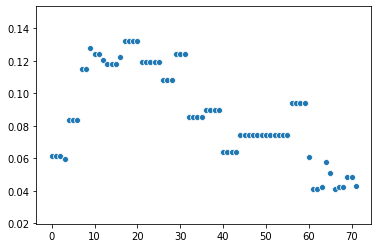

In [180]:
sns.scatterplot(np.arange(72), x[:, 12, 12, 0])

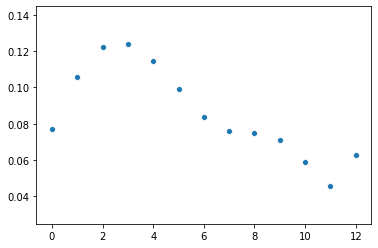

In [181]:
sns.scatterplot(np.arange(13), tiles[:, 12, 12, 0])